In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.manifold import spectral_embedding
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import pandas as pd

In [2]:
np.random.seed(42)

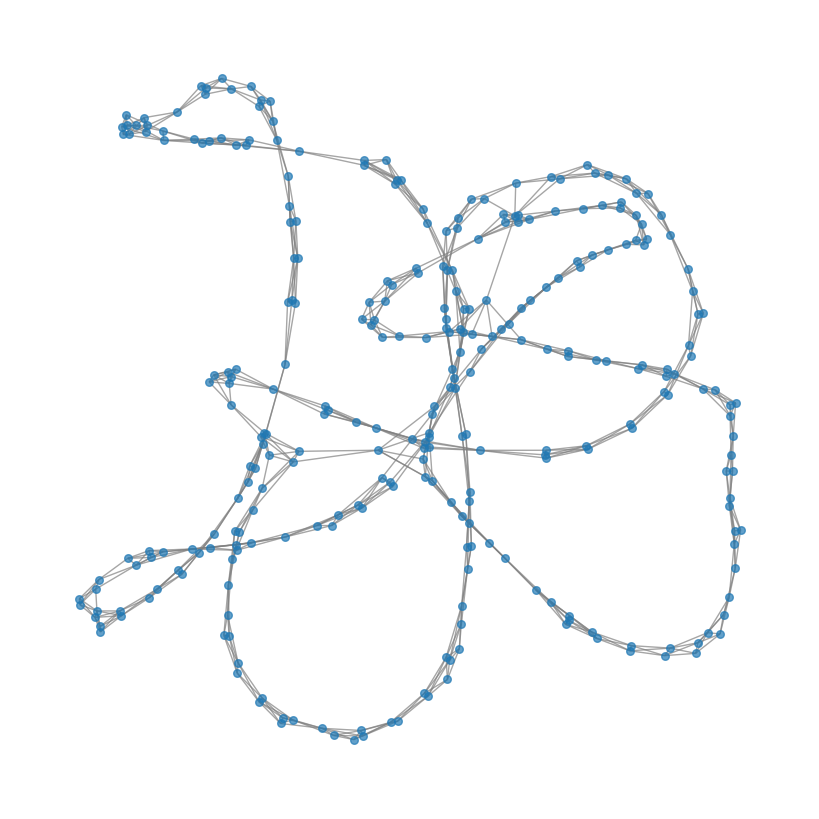

In [3]:
#Genera los anillos 
def generate_rings(n_points=100, noise=0.1):
    rings = []
    labels = []
    radii = [1.3, 2.1, 3]  
    for i, r in enumerate(radii):
        angles = np.linspace(0, 2 * np.pi, n_points)
        x = r * np.cos(angles) + noise * np.random.randn(n_points)
        y = r * np.sin(angles) + noise * np.random.randn(n_points)
        rings.append(np.vstack((x, y)).T)
        labels.extend([i] * n_points)
    return np.vstack(rings), np.array(labels)

# Genera los puntos
n_points = 100
noise = 0.1
points, labels = generate_rings(n_points, noise)

# Construye la grafica de k vecinos más cercanos
k = 5
knn_graph = kneighbors_graph(points, k, mode='connectivity', include_self=False)

# Crea el grafo
G = nx.Graph(knn_graph)

# Grafica
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=30, edge_color='gray', alpha=0.7, with_labels=False)

plt.show()





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


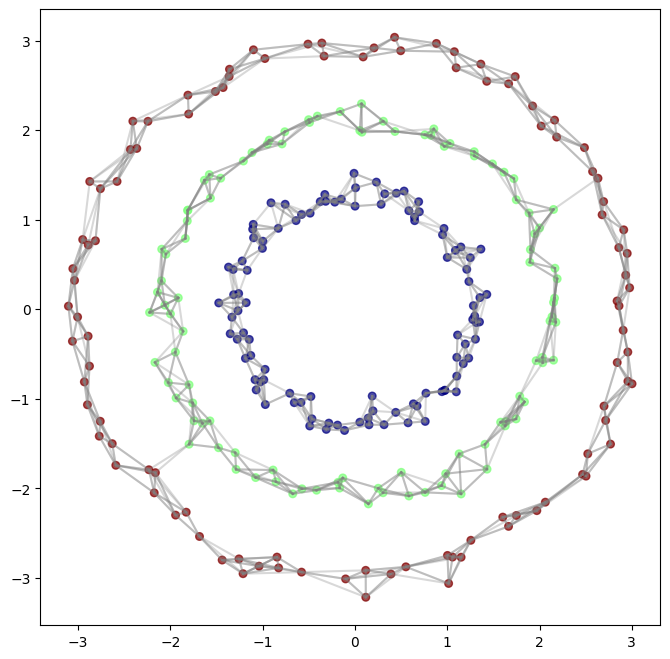

In [10]:
#Hacer el agripamiento espectral
n_clusters = 3
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
clusters = sc.fit_predict(knn_graph.toarray())

# Graficar el grafo en la proyección original con sus colores 
plt.figure(figsize=(8, 8))
for i, j in zip(*knn_graph.nonzero()):
    plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'gray', alpha=0.3)
plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap=plt.cm.jet, s=30, alpha=0.7)

plt.show()


# Laplaciano
laplacian = nx.normalized_laplacian_matrix(G)
eigenvalues, eigenvectors = sla.eigsh(laplacian, k=10, which='SM')

# Hacer eigenvectores 
eigenvectors_df = pd.DataFrame(eigenvectors, columns=[f"E_{i+1}" for i in range(eigenvectors.shape[1])])
eigenvectors_df['Cluster'] = clusters
cluster_color_map = {0: 'blue', 1: 'green', 2: 'red'}

#asignar color a cluster 
def map_cluster_to_color(cluster):
    return cluster_color_map.get(cluster)

eigenvectors_df['Cluster_Color'] = eigenvectors_df.iloc[:, -1].astype(int).map(map_cluster_to_color) # Mapeo de eigenvectores y cluster


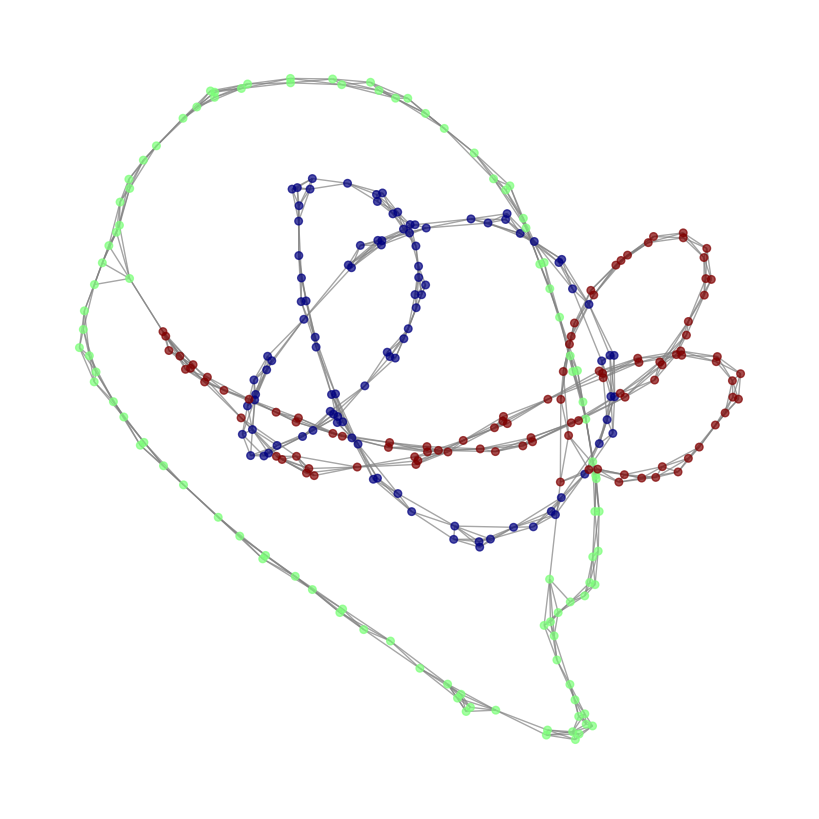

In [11]:
plt.figure(figsize=(8, 8))
nx.draw(G, node_color=clusters, cmap=plt.cm.jet, node_size=30, edge_color='gray', alpha=0.7, with_labels=False)

plt.show()


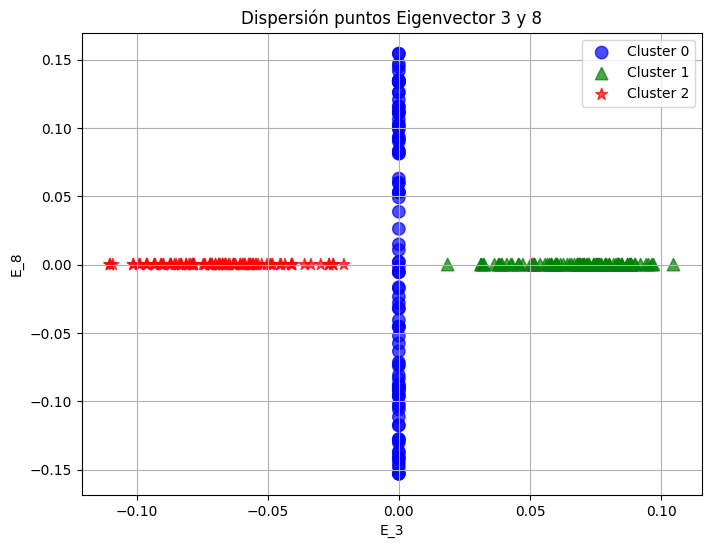

In [13]:
# Marcadores por cluster
markers = ['o', '^', '*'] 

plt.figure(figsize=(8, 6))
# Graficar eigenvectores 3 y 8
for (cluster_id, marker) in zip(eigenvectors_df['Cluster'].unique(), markers):
    subset = eigenvectors_df[eigenvectors_df['Cluster'] == cluster_id]
    plt.scatter(subset['E_3'], subset['E_8'],
                c=subset['Cluster_Color'],   # keep original colors
                marker=marker, s=80, alpha=0.7, label=f'Cluster {cluster_id}')

plt.xlabel("E_3")
plt.ylabel("E_8")
plt.title("Dispersión puntos Eigenvector 3 y 8")
plt.legend()
plt.grid(True)
plt.show()




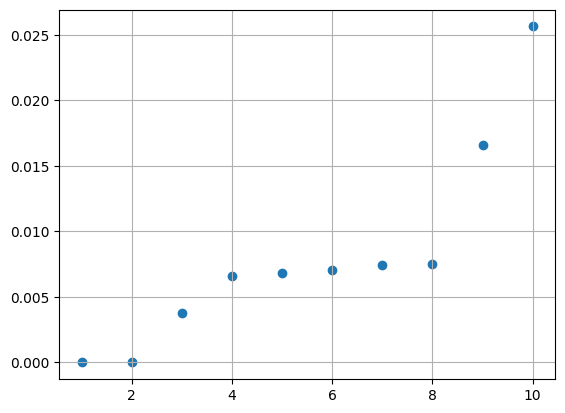

In [14]:
# Graficar eigenvectores
plt.scatter([i+1 for i in range(len(eigenvalues))],y=eigenvalues)
plt.grid()

plt.show()